In [57]:
# Libraries yang digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
# Mengabaikan Peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [58]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmads99","key":"8b016987cbe01f891b262b5d6fd9f211"}'}

In [93]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [60]:
# Download dataset dari kaggle
!kaggle datasets download -d umairshahpirzada/birds-20-species-image-classification
# Unzip dataset
!unzip birds-20-species-image-classification.zip -d dataset_folder

Dataset URL: https://www.kaggle.com/datasets/umairshahpirzada/birds-20-species-image-classification
License(s): unknown
birds-20-species-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  birds-20-species-image-classification.zip
  inflating: dataset_folder/images to predict/1.jpg  
  inflating: dataset_folder/images to predict/2.jpg  
  inflating: dataset_folder/images to predict/3.jpg  
  inflating: dataset_folder/images to predict/4.jpg  
  inflating: dataset_folder/images to predict/5.jpg  
  inflating: dataset_folder/images to predict/6.jpg  
  inflating: dataset_folder/test/ABBOTTS BABBLER/1.jpg  
  inflating: dataset_folder/test/ABBOTTS BABBLER/2.jpg  
  inflating: dataset_folder/test/ABBOTTS BABBLER/3.jpg  
  inflating: dataset_folder/test/ABBOTTS BABBLER/4.jpg  
  inflating: dataset_folder/test/ABBOTTS BABBLER/5.jpg  
  inflating: dataset_folder/test/ABBOTTS BOOBY/1.jpg  
  inflating: dataset_folder/test/ABBOTT

In [142]:
dataset_path = 'dataset_folder/train'
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Jumlah Data: {count}")


Class: AFRICAN EMERALD CUCKOO, Jumlah Data: 154
Class: AMERICAN KESTREL, Jumlah Data: 155
Class: AFRICAN PYGMY GOOSE, Jumlah Data: 179
Class: ABBOTTS BOOBY, Jumlah Data: 180
Class: AMERICAN COOT, Jumlah Data: 158
Class: AMERICAN BITTERN, Jumlah Data: 170
Class: AFRICAN FIREFINCH, Jumlah Data: 137
Class: AFRICAN CROWNED CRANE, Jumlah Data: 137
Class: ALBERTS TOWHEE, Jumlah Data: 161
Class: ABYSSINIAN GROUND HORNBILL, Jumlah Data: 179
Class: AFRICAN OYSTER CATCHER, Jumlah Data: 155
Class: ALTAMIRA YELLOWTHROAT, Jumlah Data: 150
Class: ALPINE CHOUGH, Jumlah Data: 166
Class: ALBATROSS, Jumlah Data: 133
Class: AMERICAN GOLDFINCH, Jumlah Data: 133
Class: AMERICAN FLAMINGO, Jumlah Data: 164
Class: ABBOTTS BABBLER, Jumlah Data: 166
Class: AFRICAN PIED HORNBILL, Jumlah Data: 187
Class: ALEXANDRINE PARAKEET, Jumlah Data: 165
Class: AMERICAN AVOCET, Jumlah Data: 179


In [143]:
import random
import shutil

random.seed(42)  # Reproducibility

base_output = 'dataset_split'
split_ratio = {'train': 0.8, 'val': 0.2, 'test': 0.2}

# Buat folder struktur
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_path):
        os.makedirs(os.path.join(base_output, split, class_name), exist_ok=True)

# Bagi data
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        total = len(all_images)
        train_end = int(total * split_ratio['train'])
        val_end = train_end + int(total * split_ratio['val'])

        splits = {
            'train': all_images[:train_end],
            'val': all_images[train_end:val_end],
            'test': all_images[val_end:]
        }

        for split, images in splits.items():
            for img in images:
                src = os.path.join(class_path, img)
                dst = os.path.join(base_output, split, class_name, img)
                shutil.copyfile(src, dst)

print("Dataset berhasil dibagi ke dalam train, val, dan test.")


Dataset berhasil dibagi ke dalam train, val, dan test.


In [144]:
import tensorflow as tf

base_dir = 'dataset_split'
img_size = (150, 150)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

Found 3061 files belonging to 20 classes.
Found 878 files belonging to 20 classes.
Found 634 files belonging to 20 classes.


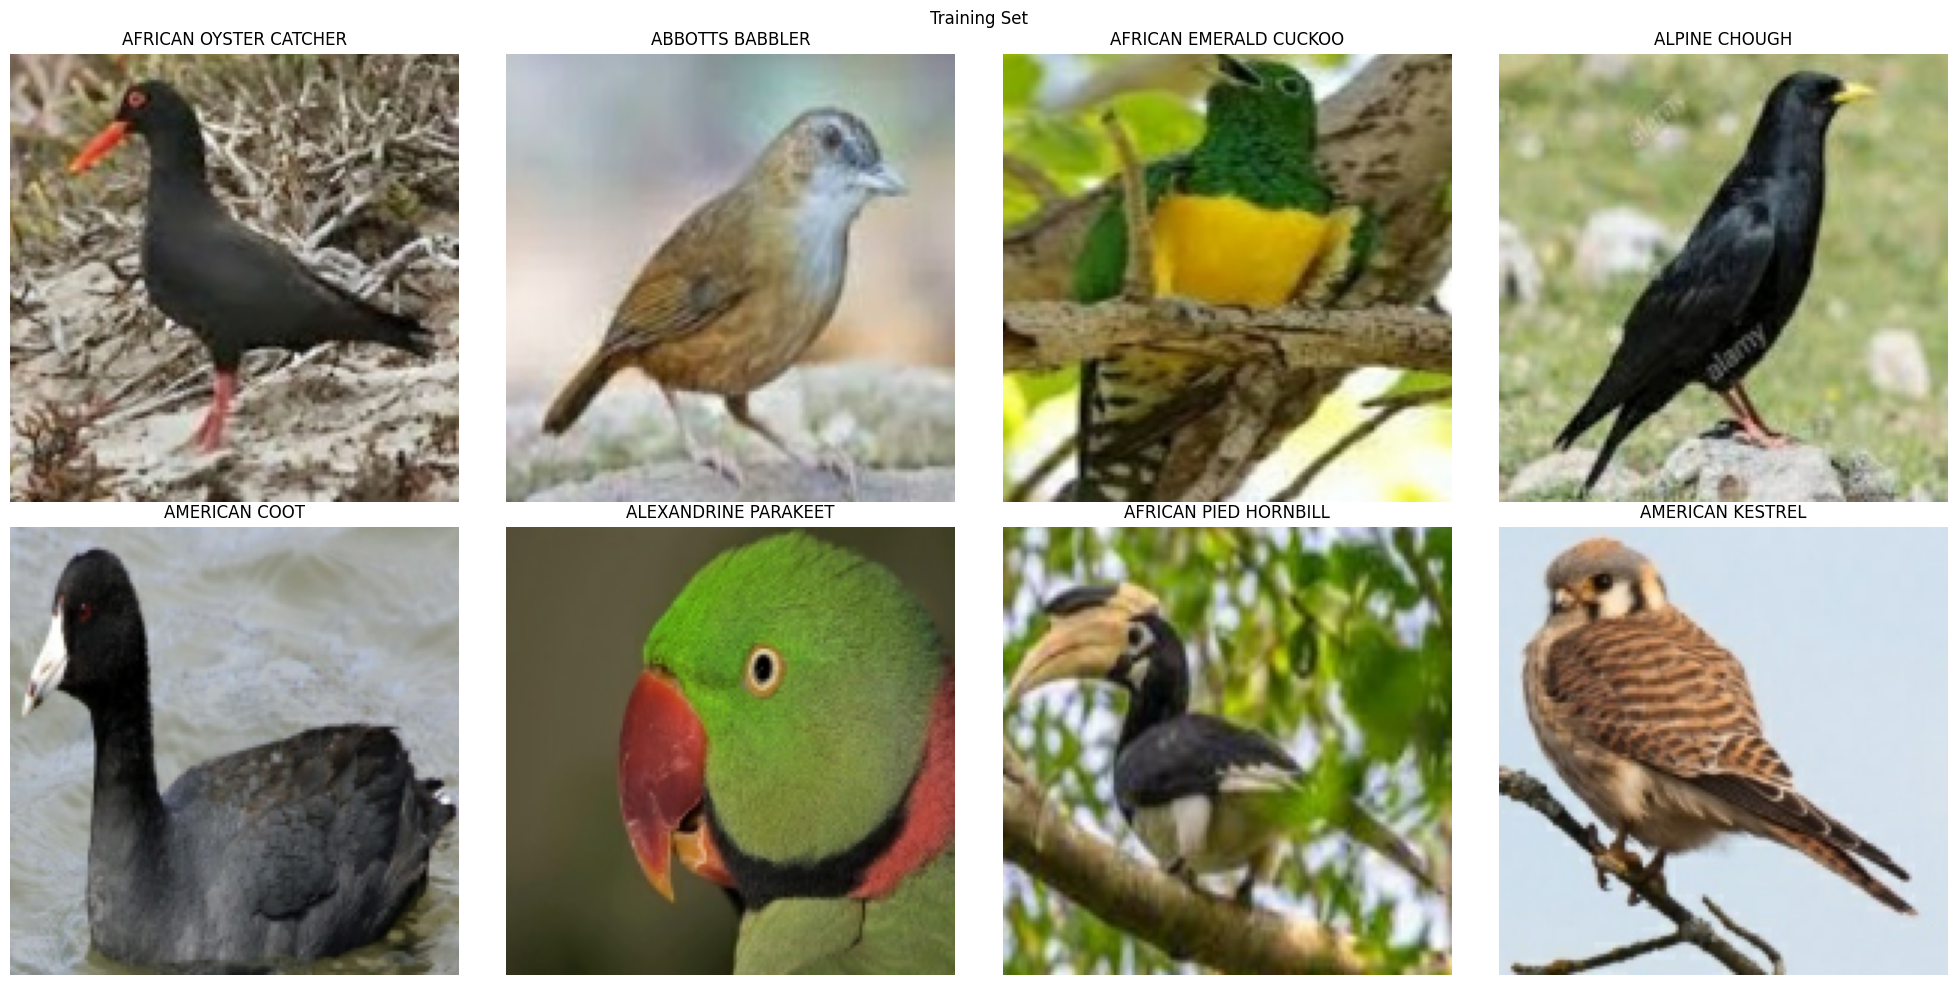

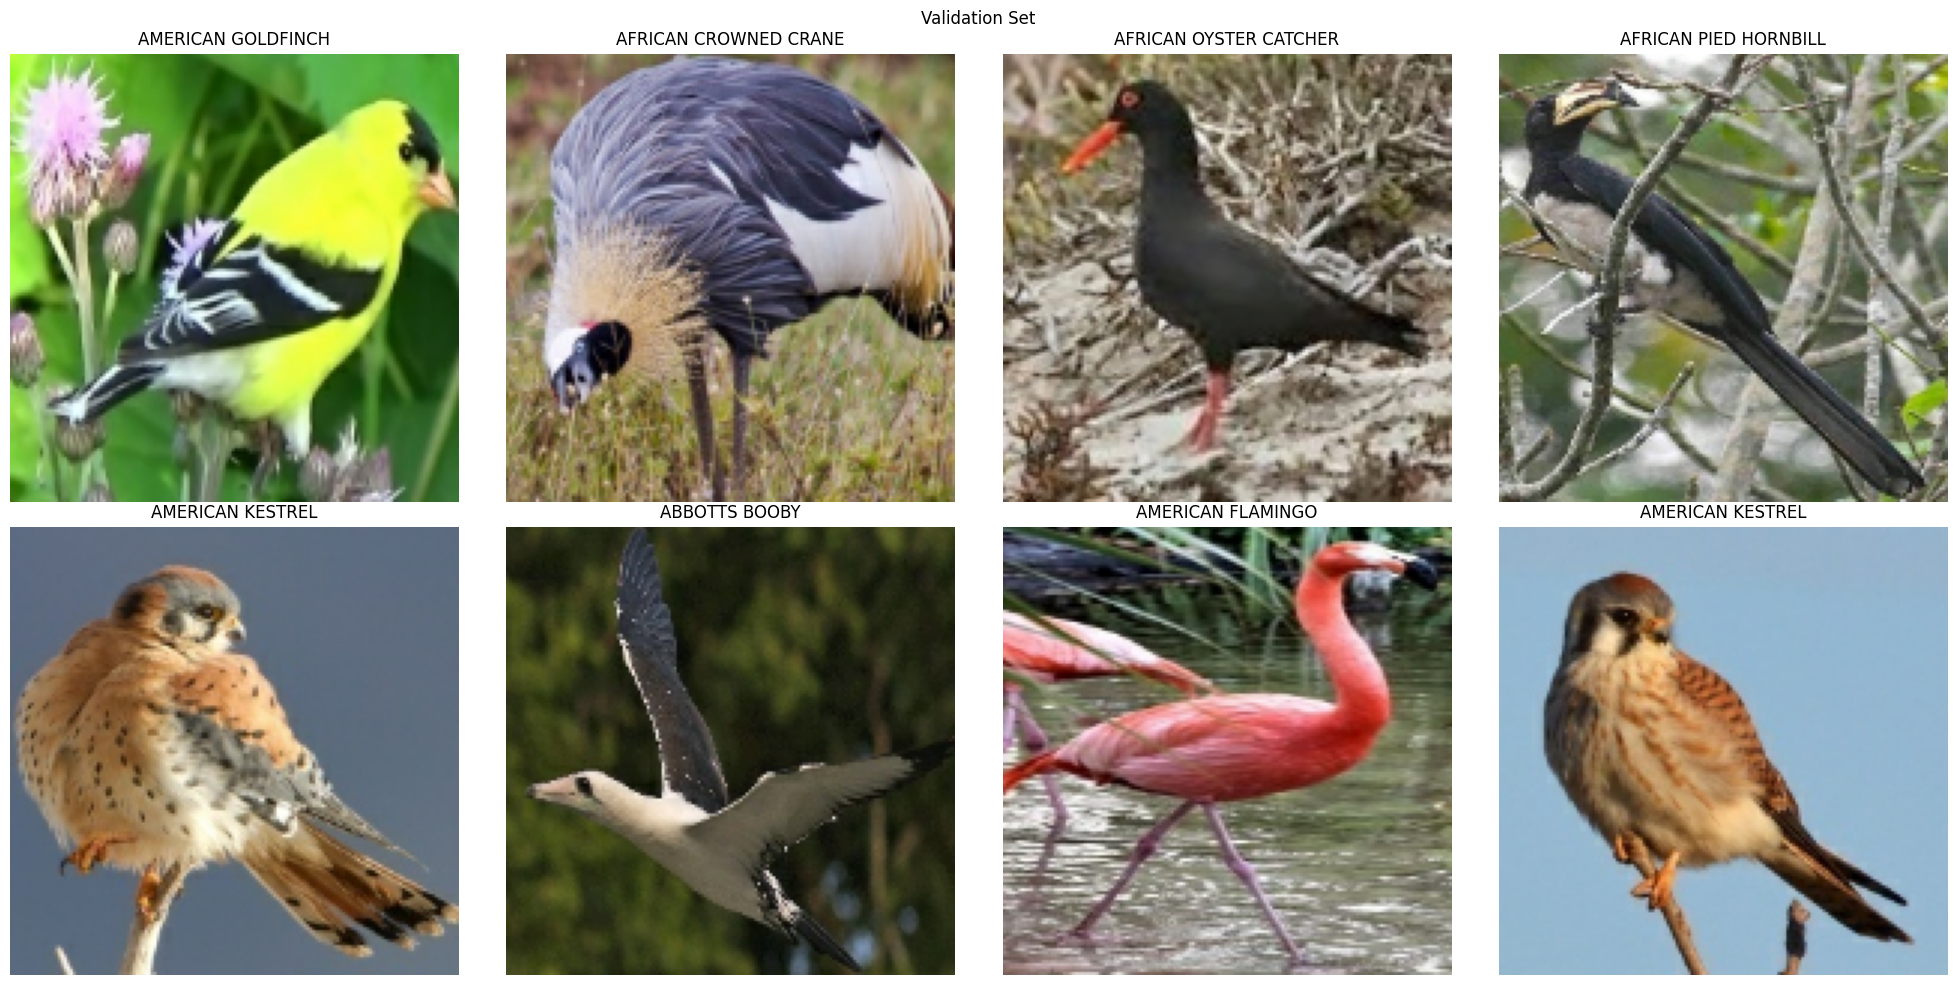

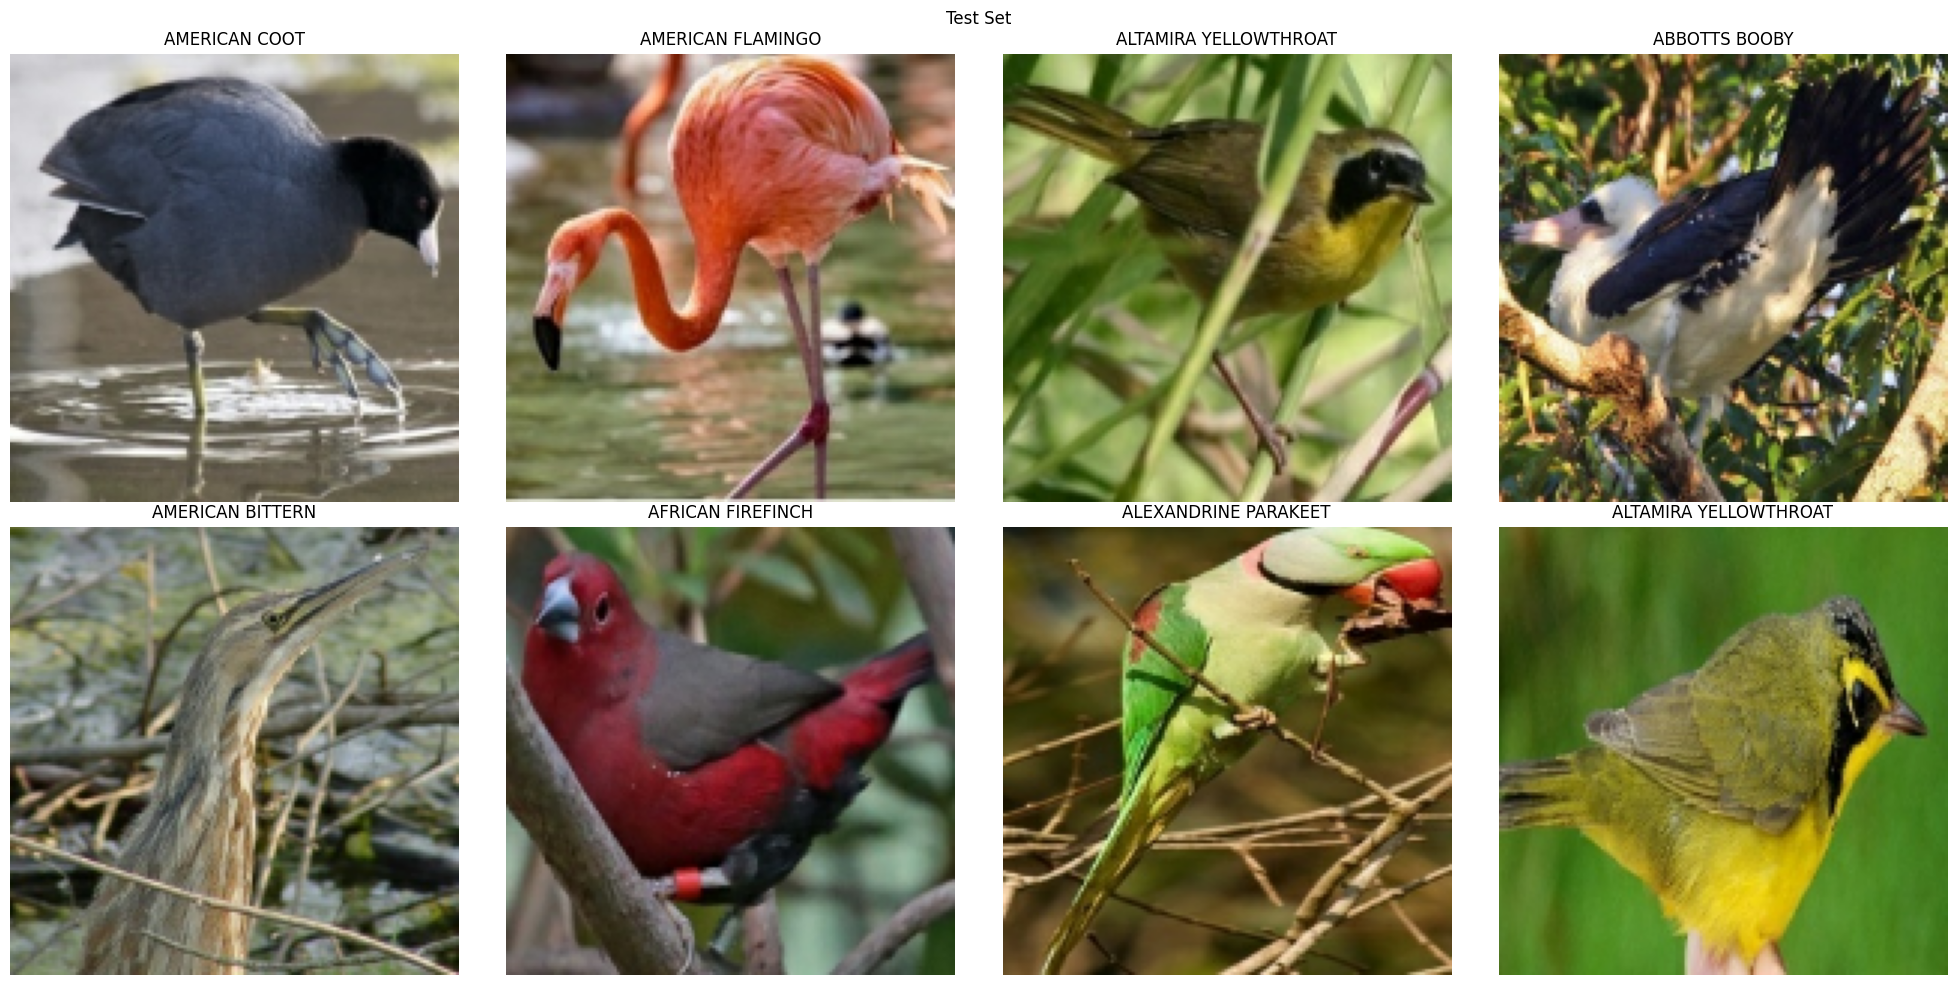

In [145]:
import matplotlib.pyplot as plt
import tensorflow as tf

class_names = train_ds.class_names

def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(20, 10))
    for images, labels in dataset.take(1):  # Ambil 1 batch dari dataset
        for i in range(min(8, images.shape[0])): # Tampilkan hingga 8 gambar atau sesuai jumlah gambar dalam batch
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(train_ds, title="Training Set")
show_images(val_ds, title="Validation Set")
show_images(test_ds, title="Test Set")

In [146]:
# Data augmentasi
# Data augmentasi
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("both"),
    layers.RandomRotation(0.2),
    layers.RandomShear(0.1),
    layers.RandomContrast(0.1),
    layers.RandomZoom(0.1)
])

In [147]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    # Data Augmentation
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    # Convolutional Layers
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Dropout & Flatten
    layers.Dropout(0.4),
    layers.Flatten(),

    # Dense Layers
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(20, activation='softmax')  # Output layer for 20 classes
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [148]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.86 and logs.get('accuracy')>0.86):
      print("\nAkurasi telah mencapai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [149]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.2697 - loss: 4.6935 - val_accuracy: 0.3098 - val_loss: 4.4546
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5229 - loss: 3.0949 - val_accuracy: 0.4499 - val_loss: 3.9035
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.5937 - loss: 2.5307 - val_accuracy: 0.5718 - val_loss: 3.3848
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6173 - loss: 2.3145 - val_accuracy: 0.6173 - val_loss: 2.9000
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6531 - loss: 2.1041 - val_accuracy: 0.6059 - val_loss: 2.5904
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6688 - loss: 2.0589 - val_accuracy: 0.6925 - val_loss: 2.1012
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6916 - loss: 1.9472 - val_accuracy: 0.6777 - val_loss: 2.0433
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6873 - loss: 1.9283 - val_accuracy: 0.7118 - v

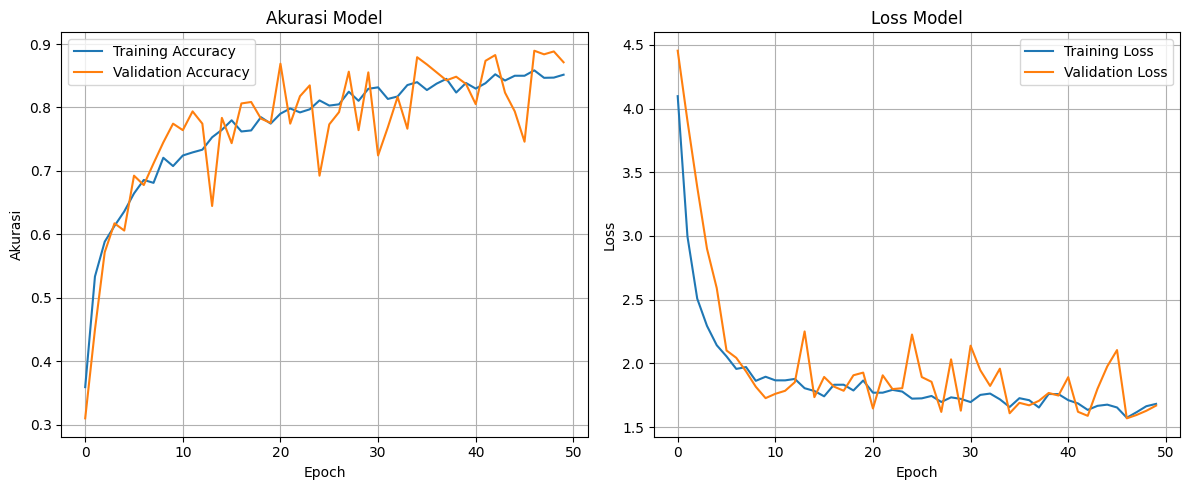

In [150]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [152]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Akurasi di test set: {test_acc:.2%}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step - accuracy: 0.8704 - loss: 1.6547
Akurasi di test set: 85.65%


**Konversi Model**

In [153]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [154]:
# Konversi ke Saved_model
model.export('save_model')

Saved artifact at 'save_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_90')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  134971700922512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971700930192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971700930960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971703711632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971703712400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971703708560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971703709328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971703715664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971703707216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971703710096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134971703718736:

In [155]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("save_model")
converter.experimental_new_converter = True  # Enable the new MLIR-based converter if available.
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Simpan model.tflite
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt jika ada label
labels = ["AFRICAN EMERALD CUCKOO", "AMERICAN KESTREL", "AFRICAN PYGMY GOOSE", "ABBOTTS BOOBY", "AMERICAN COOT", "AMERICAN BITTERN",
          "AFRICAN FIREFINCH", "AFRICAN CROWNED CRANE", "ALBERTS TOWHEE", "ABYSSINIAN GROUND HORNBILL", "AFRICAN OYSTER CATCHER",
          "ALTAMIRA YELLOWTHROAT", "ALPINE CHOUGH", "ALBATROSS", "AMERICAN GOLDFINCH", "AMERICAN FLAMINGO", "ABBOTTS BABBLER",
          "AFRICAN PIED HORNBILL", "ALEXANDRINE PARAKEET", "AMERICAN AVOCET"]
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")


In [156]:
# Install TensorFlow.js converter
!pip install tensorflowjs

# Import library tensorflowjs
import tensorflowjs as tfjs

# Buat direktori untuk menyimpan model TFJS
!mkdir -p tfjs_model

# Simpan model ke format TFJS
tfjs.converters.save_keras_model(model, 'tfjs_model')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file


In [158]:
# Zip semua model yang disimpan
!zip -r model_zip.zip save_model tfjs_model tflite
# Download hasil zip
files.download("model_zip.zip")

  adding: save_model/ (stored 0%)
  adding: save_model/saved_model.pb (deflated 89%)
  adding: save_model/fingerprint.pb (stored 0%)
  adding: save_model/assets/ (stored 0%)
  adding: save_model/variables/ (stored 0%)
  adding: save_model/variables/variables.index (deflated 67%)
  adding: save_model/variables/variables.data-00000-of-00001 (deflated 5%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard4of5.bin (deflated 5%)
  adding: tfjs_model/group1-shard5of5.bin (deflated 5%)
  adding: tfjs_model/group1-shard3of5.bin (deflated 5%)
  adding: tfjs_model/group1-shard2of5.bin (deflated 5%)
  adding: tfjs_model/model.json (deflated 86%)
  adding: tfjs_model/group1-shard1of5.bin (deflated 5%)
  adding: tflite/ (stored 0%)
  adding: tflite/label.txt (deflated 48%)
  adding: tflite/model.tflite (deflated 5%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Inference (Optional)**

In [170]:
# Load model dari folder SavedModel
model = tf.saved_model.load("save_model")

In [175]:
# Upload file gambar (misal .jpg)
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving 010.jpg to 010.jpg


Output prediksi: {'output_0': <tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0.05118759, 0.11647527, 0.03222797, 0.02008644, 0.01308152,
        0.09443791, 0.03838212, 0.01953969, 0.03346932, 0.14588991,
        0.08515456, 0.02627622, 0.04457833, 0.02563357, 0.1063033 ,
        0.02627522, 0.05886037, 0.04146977, 0.00876355, 0.01190745]],
      dtype=float32)>}
Prediksi kelas: 0
Prediksi label: AFRICAN EMERALD CUCKOO


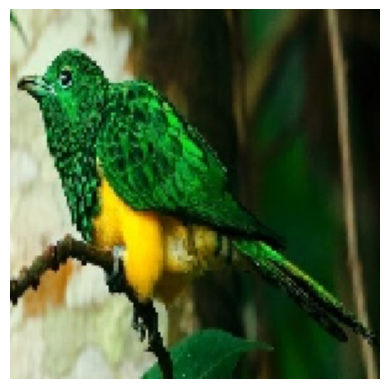

In [176]:
# Load dan resize gambar
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalisasi
img_array = np.expand_dims(img_array, axis=0)  # tambah batch dimensi

# predictions = model.predict(img_array)
# Cara baru dengan SaveModel
input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
infer = model.signatures["serving_default"]
input_name = list(infer.structured_input_signature[1].keys())[0]
predictions = infer(**{input_name: input_tensor})

# Hasil prediksi (probabilitas per kelas)
print("Output prediksi:", predictions)
# Ambil kelas dengan skor tertinggi
class_index = np.argmax(predictions)
print("Prediksi kelas:", class_index)
# Kelas berdasarkan index
labels = ["AFRICAN EMERALD CUCKOO", "AMERICAN KESTREL", "AFRICAN PYGMY GOOSE", "ABBOTTS BOOBY", "AMERICAN COOT", "AMERICAN BITTERN",
          "AFRICAN FIREFINCH", "AFRICAN CROWNED CRANE", "ALBERTS TOWHEE", "ABYSSINIAN GROUND HORNBILL", "AFRICAN OYSTER CATCHER",
          "ALTAMIRA YELLOWTHROAT", "ALPINE CHOUGH", "ALBATROSS", "AMERICAN GOLDFINCH", "AMERICAN FLAMINGO", "ABBOTTS BABBLER",
          "AFRICAN PIED HORNBILL", "ALEXANDRINE PARAKEET", "AMERICAN AVOCET"]
print("Prediksi label:", labels[class_index])

plt.imshow(img)
plt.axis("off")
plt.show()

In [179]:
!pip freeze > requirements.txt